# Sundial: Zero-Shot Blood Glucose Forecasting

**Model**: thuml/sundial-base-128m (128M parameters)  
**Dataset**: Kaggle BrisT1D  
**Task**: Nocturnal blood glucose forecasting (6 hours)

**Requirements:** `pip install transformers`

Sundial is a generative time series foundation model (ICML 2025 Oral) pretrained on 1 trillion time points. It generates multiple probable predictions, allowing estimation of means, quantiles, and confidence intervals.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from transformers import AutoModelForCausalLM

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import iter_daily_context_forecast_splits

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


def compute_metrics(predictions, targets):
    """Compute RMSE, MAE, MAPE for forecast evaluation."""
    y_pred = np.asarray(predictions).flatten()
    y_true = np.asarray(targets).flatten()
    return {
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(
            np.mean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, 1e-8)))
            * 100
        ),
    }

Device: cpu


In [2]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
TARGET_COL = ColumnNames.BG.value

nocturnal_steps = int(NOCTURNAL_HOURS * 60 / INTERVAL_MINS)  # 72 steps
print(f"Predicting {nocturnal_steps} steps ({NOCTURNAL_HOURS} hours)")

Predicting 72 steps (6 hours)


In [3]:
# Load data
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)
val_data = loader.validation_data

# Load Sundial model
print("Loading Sundial model...")
model = AutoModelForCausalLM.from_pretrained(
    "thuml/sundial-base-128m",
    trust_remote_code=True
)
model.to(device)
model.eval()
print("Model loaded.")

2026-01-13T21:42:04 - ============================================================
2026-01-13T21:42:04 - Beginning data loading process with the following parmeters:
2026-01-13T21:42:04 - 	Dataset: kaggle_brisT1D - train
2026-01-13T21:42:04 - 	Columns: None
2026-01-13T21:42:04 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-13T21:42:04 - 	Number of validation days: 20
2026-01-13T21:42:04 - 	In parallel with up to 3 workers.

2026-01-13T21:42:05 - Loaded full processed data from cache for 9 patients
2026-01-13T21:42:05 - Loaded existing train/validation split from cache for 9 patients
/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading Sundial model...
Model loaded.


/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
def sundial_forecast(
    context: np.ndarray,
    timestamps: pd.DatetimeIndex,  # unused by Sundial but kept for API consistency
    prediction_length: int,
    num_samples: int = 100,
):
    """
    Run Sundial forecast on univariate context.

    Returns: (median, q05, q95) prediction arrays for 90% PI
    """
    # Prepare input tensor
    seqs = torch.tensor(context, dtype=torch.float32).unsqueeze(0).to(device)

    # Generate samples
    with torch.no_grad():
        samples = model.generate(
            seqs,
            max_new_tokens=prediction_length,
            num_samples=num_samples
        )  # shape: (1, num_samples, prediction_length)

    samples = samples.cpu().numpy()[0]  # (num_samples, prediction_length)

    # Compute quantiles for 90% PI
    median = np.median(samples, axis=0)
    q05 = np.percentile(samples, 5, axis=0)
    q95 = np.percentile(samples, 95, axis=0)

    return median, q05, q95

## Evaluation

Evaluate using day-split validation:
- **Context**: Daytime data (6am-midnight)
- **Target**: Nocturnal period (midnight-6am next day)

In [5]:
# Store per-day results for visualization
day_results = []

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue

    for daytime, nocturnal in iter_daily_context_forecast_splits(patient_df):
        context = daytime[TARGET_COL].values
        target = nocturnal[TARGET_COL].values[:nocturnal_steps]

        if np.isnan(context).any() or np.isnan(target).any():
            continue
        if len(context) < 10 or len(target) < nocturnal_steps:
            continue

        pred, q05, q95 = sundial_forecast(context, daytime.index, nocturnal_steps)

        day_results.append(
            {
                "patient": patient_id,
                "context": context,
                "timestamps": daytime.index,
                "target": target,
                "pred": pred.flatten(),
                "q05": q05.flatten(),
                "q95": q95.flatten(),
                "daytime_df": daytime,  # Keep for CoRA covariates
            }
        )

# Aggregate metrics by patient
patient_metrics = []
for pid in set(r["patient"] for r in day_results):
    patient_days = [r for r in day_results if r["patient"] == pid]
    preds = np.concatenate([r["pred"] for r in patient_days])
    targets = np.concatenate([r["target"] for r in patient_days])
    metrics = compute_metrics(preds, targets)
    patient_metrics.append(
        {
            "patient": pid,
            "rmse": metrics["rmse"],
            "mae": metrics["mae"],
            "days": len(patient_days),
        }
    )
    print(
        f"{pid}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(patient_days)} days)"
    )

# Overall metrics
all_preds = np.concatenate([r["pred"] for r in day_results])
all_targets = np.concatenate([r["target"] for r in day_results])
overall = compute_metrics(all_preds, all_targets)
print(
    f"\nOverall: RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}, MAPE={overall['mape']:.1f}%"
)

p02: RMSE=3.208, MAE=2.474 (16 days)
p11: RMSE=2.193, MAE=1.797 (17 days)
p12: RMSE=2.852, MAE=2.098 (16 days)
p03: RMSE=3.292, MAE=2.498 (18 days)
p04: RMSE=1.774, MAE=1.396 (16 days)
p10: RMSE=1.409, MAE=1.049 (15 days)

Overall: RMSE=2.579, MAE=1.906, MAPE=23.9%


In [6]:
pd.DataFrame(patient_metrics)

,patient,rmse,mae,days
0,p02,3.207833,2.474469,16
1,p11,2.192668,1.796822,17
2,p12,2.851683,2.097747,16
3,p03,3.292160,2.498400,18
4,p04,1.773706,1.396406,16
5,p10,1.408610,1.048881,15


## Visualization

Example forecast with 90% prediction interval (q05-q95).

Patient p10: 15 valid days


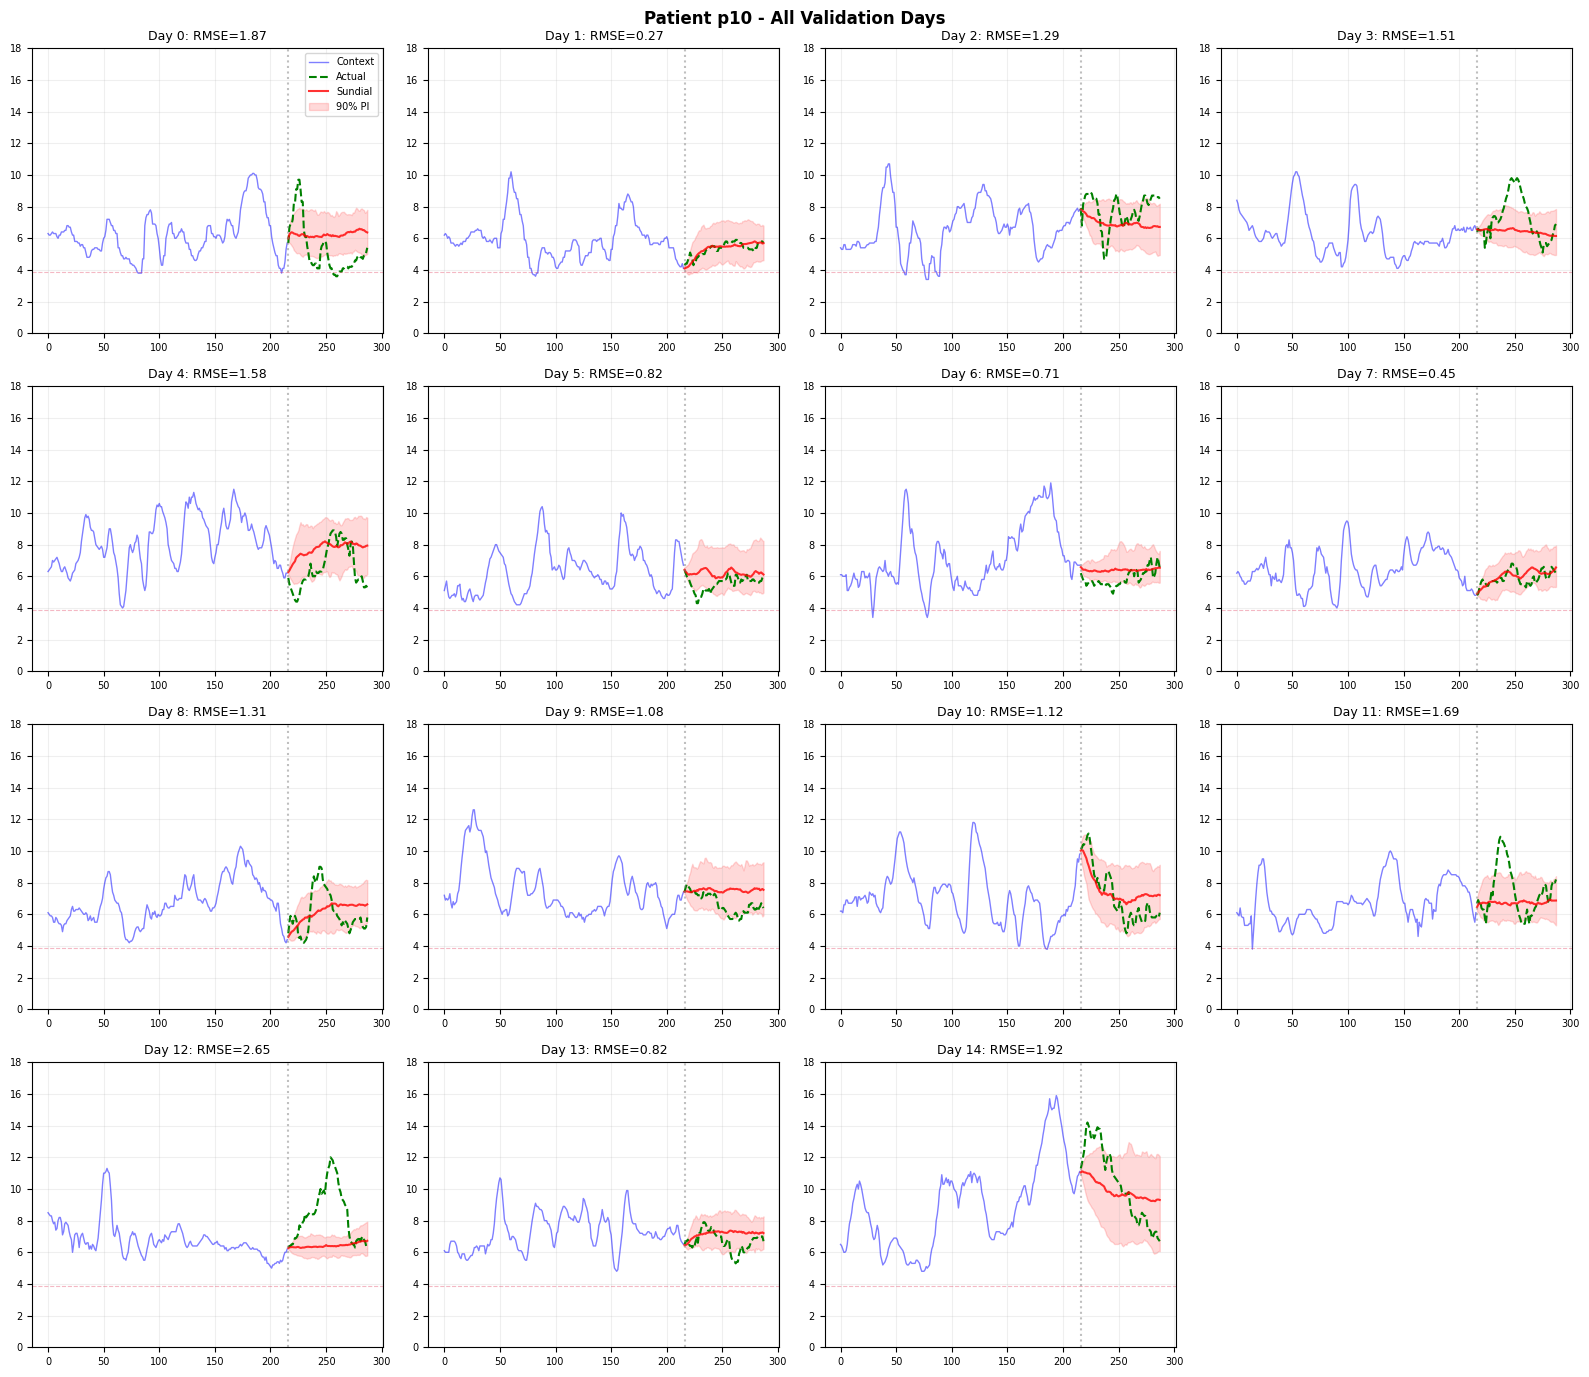

In [7]:
# Plot all days for a patient
PATIENT = "p10"
NCOLS = 4

patient_days = [r for r in day_results if r["patient"] == PATIENT]
num_days = len(patient_days)
print(f"Patient {PATIENT}: {num_days} valid days")

if num_days > 0:
    nrows = int(np.ceil(num_days / NCOLS))
    fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
    axes = np.array(axes).flatten() if num_days > 1 else [axes]

    for i, day in enumerate(patient_days):
        ax = axes[i]
        context, target = day["context"], day["target"]
        pred, q05, q95 = day["pred"], day["q05"], day["q95"]

        t_ctx = np.arange(len(context))
        t_pred = np.arange(len(context), len(context) + len(target))

        ax.plot(t_ctx, context, "b-", alpha=0.5, lw=1, label="Context")
        ax.plot(t_pred, target, "g--", lw=1.5, label="Actual")
        ax.plot(t_pred, pred, "r-", lw=1.5, alpha=0.8, label="Sundial")
        ax.fill_between(t_pred, q05, q95, alpha=0.15, color="red", label="90% PI")

        ax.axvline(len(context), color="gray", ls=":", alpha=0.5)
        ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)

        rmse = compute_metrics(pred, target)["rmse"]
        ax.set_title(f"Day {i}: RMSE={rmse:.2f}", fontsize=9)
        ax.set_ylim(0, 18)
        ax.tick_params(labelsize=7)
        ax.grid(alpha=0.2)

    for j in range(num_days, len(axes)):
        axes[j].set_visible(False)

    axes[0].legend(fontsize=7, loc="upper right")
    fig.suptitle(f"Patient {PATIENT} - All Validation Days", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()